# **ISIC 2016 Challenge - Lesion Segmentation**

# **Imports and data loading**

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O
import os # os functionalities
from skimage import io  # image manipulation
from matplotlib import pyplot as plt # image visualization

from PIL import ImageOps

In [2]:
# Variable declaration
input_dir = "../input/isic-2016-challenge-lesion-segmentation/ISBI2016_ISIC_Part1_Training_Data/ISBI2016_ISIC_Part1_Training_Data"
target_dir = "../input/isic-2016-challenge-lesion-segmentation/ISBI2016_ISIC_Part1_Training_GroundTruth/ISBI2016_ISIC_Part1_Training_GroundTruth"

# Read training images and get their shape
img1 = io.imread(f'{input_dir}/ISIC_0000025.jpg')
img_shape = np.shape(img1)
print(f"The shape of the pictures in the training set is: {img_shape}")

# Read target images and get their shape
img1 = io.imread(f'{target_dir}/ISIC_0000025_Segmentation.png')
img_shape = np.shape(img1)
print(f"The shape of the pictures in the target set is: {img_shape}")

#img_size = img_shape[0:2]
img_size = (160, 160)
batch_size = 8

"""HOW DO I MANAGE THIS???????"""
num_classes = 2

The shape of the pictures in the training set is: (1129, 1504, 3)
The shape of the pictures in the target set is: (1129, 1504)


In [3]:
# Get paths to the training and target images
input_img_paths = sorted([
    os.path.join(input_dir, fname)
    for fname in os.listdir(input_dir)
    if fname.endswith(".jpg")])

target_img_paths = sorted([
    os.path.join(target_dir, fname)
    for fname in os.listdir(target_dir)
    if fname.endswith(".png") and not fname.startswith(".")])

# Check if dimentions are equal
print("Number of samples in the training set:", len(input_img_paths))
print("Number of samples in the target set:", len(target_img_paths))

Number of samples in the training set: 900
Number of samples in the target set: 900


# **Data visualization**

Text(0.5, 1.0, 'Segmentation mask')

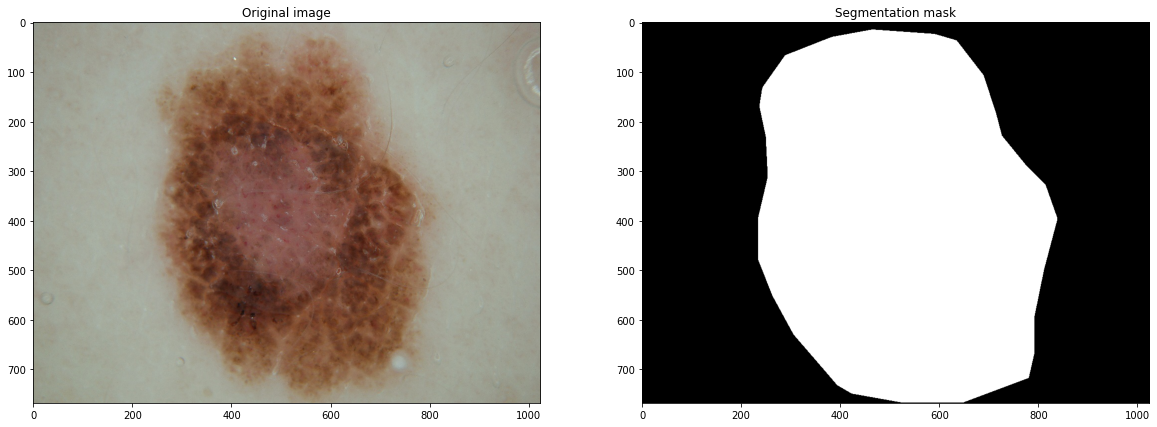

In [4]:
# Visualize an image and it's segmentation
image_to_visualize = 500

# Create figure
fig = plt.figure(figsize=(20, 20))

# Cetting values to rows and column variables
rows = 1
columns = 2

# Plot images
fig.add_subplot(rows, columns, 1)
plt.imshow(io.imread(input_img_paths[image_to_visualize]))
plt.title("Original image")

fig.add_subplot(rows, columns, 2)
plt.imshow(io.imread(target_img_paths[image_to_visualize]), cmap='gray')


#plt.imshow(io.imread(target_img_paths[image_to_visualize]))
plt.title("Segmentation mask")

In [5]:
from tensorflow.keras.preprocessing.image import load_img
from PIL import Image
import tensorflow as tf

'''img = load_img(input_img_paths[0], target_size=(128, 128))
#print(type(img))
#normalized = np.array(img)/255
#normalized

x = tf.cast(img, tf.float32)/255.0


type(x)'''

'img = load_img(input_img_paths[0], target_size=(128, 128))\n#print(type(img))\n#normalized = np.array(img)/255\n#normalized\n\nx = tf.cast(img, tf.float32)/255.0\n\n\ntype(x)'

In [6]:
img = load_img(target_img_paths[0], target_size=(128, 128))

print(np.shape(img))

print(np.shape(np.expand_dims(img, 2)))

img = np.array(img)/255

np.max(np.array(img))

(128, 128, 3)
(128, 128, 1, 3)


1.0

# **Load and vectorize batches of data**

Sequence structure guarantees that the network will only train once on each sample per epoch which is not the case with generators. Thus, is a safer way to do multiprocessing.

In [7]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img


class LesionSegmentation(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = tf.cast(img, tf.float32)/255.0
            
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            img = np.array(img)/255
            y[j] = np.expand_dims(img.astype(int), 2)
            # Ground truth labels are 1, 2. Subtract one to make them 0, 1:
            y[j] -= 1
            
        return x, y


In [8]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    
    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    
    print(inputs)
    print("\nHello\n")
    print(outputs)
    #print(tf.reshape(outputs[0], [767, 1022, 1]))
    
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

2022-10-07 18:05:48.232631: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-07 18:05:48.312774: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-07 18:05:48.313566: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-07 18:05:48.314791: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

KerasTensor(type_spec=TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")

Hello

KerasTensor(type_spec=TensorSpec(shape=(None, 160, 160, 2), dtype=tf.float32, name=None), name='conv2d_8/Softmax:0', description="created by layer 'conv2d_8'")
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 80, 80, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 80, 80, 32)   128         conv2

In [9]:
import random

# Split our img paths into a training and a validation set
val_samples = 890
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = LesionSegmentation(batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_gen = LesionSegmentation(batch_size, img_size, val_input_img_paths, val_target_img_paths)

In [10]:
import tensorflow as tf

'''config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
'''
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy because our target data is integers.
model.compile(optimizer="rmsprop", loss="categorical_crossentropy")

#callbacks = [keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)]

# Train the model, doing validation at the end of each epoch.
epochs = 1
model.fit(train_gen, epochs=epochs, validation_data=val_gen)
#model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

2022-10-07 18:05:51.679882: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-10-07 18:05:56.219013: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1/1 [==============================] - 67s 67s/step - loss: 1484.2778 - val_loss: 272.6021


In [11]:
'''from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
from PIL import ImageOps

# Generate predictions for all images in the validation set

val_gen = LesionSegmentation(batch_size, img_size, val_input_img_paths, val_target_img_paths, img_size)
val_preds = model.predict(val_gen)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for validation image #10
i = 10

# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
img = ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.'''

'from IPython.display import Image, display\nfrom tensorflow.keras.preprocessing.image import load_img\nfrom PIL import ImageOps\n\n# Generate predictions for all images in the validation set\n\nval_gen = LesionSegmentation(batch_size, img_size, val_input_img_paths, val_target_img_paths, img_size)\nval_preds = model.predict(val_gen)\n\n\ndef display_mask(i):\n    """Quick utility to display a model\'s prediction."""\n    mask = np.argmax(val_preds[i], axis=-1)\n    mask = np.expand_dims(mask, axis=-1)\n    img = ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))\n    display(img)\n\n\n# Display results for validation image #10\ni = 10\n\n# Display input image\ndisplay(Image(filename=val_input_img_paths[i]))\n\n# Display ground-truth target mask\nimg = ImageOps.autocontrast(load_img(val_target_img_paths[i]))\ndisplay(img)\n\n# Display mask predicted by our model\ndisplay_mask(i)  # Note that the model only sees inputs at 150x150.'

NOTES: Set aside data for validation purposes